# Setup and Data

In [11]:
import pandas as pd
import pyreadstat
from tabulate import tabulate
import matplotlib.pyplot as plt

# Parameters
start_year = 2021
end_year = 2022
low_income_decile=1 # 1-10
high_income_decile=9 # 1-10
low_ses_cutoff=1 # 1-5
high_ses_cutoff=5 # 1-5
young_age_cutoff=25
old_age_threshold=65
years=range(start_year,end_year+1)

# Load folder names
folder_names_pathname='Data_clean/CEX_folder_names.csv'
folder_names_df = pd.read_csv(folder_names_pathname)

# CEX data folder
cex_data_folder='/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/'

In [12]:
# Load age groups
age_groups_pathname='Data_clean/age_groups.csv'
age_groups_df = pd.read_csv(age_groups_pathname)
young_age_group_id = age_groups_df[(age_groups_df['min_age'] <= young_age_cutoff) & (age_groups_df['max_age'] >= young_age_cutoff)].index[0]+1
old_age_group_id = age_groups_df[(age_groups_df['min_age'] <= old_age_threshold) & (age_groups_df['max_age'] >= old_age_threshold)].index[0]+1

# Load household data for each year
dfs_HH = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_HH_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datamb.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_HH_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    dfs_HH[year] = df

# Load individual data for each year
dfs_IND = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_IND_pathname = f"{cex_data_folder}{subfolder}/{subfolder}dataprat.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_IND_pathname)
    df.columns = df.columns.str.lower()
    if 'gil' in df.columns:
        df.rename(columns={'gil': 'age_group'}, inplace=True)
    dfs_IND[year] = df

# Print columns names
last_year = max(years)
print(f"Columns for year {last_year}:\n")
columns_last_year = dfs_HH[last_year].columns.tolist()
print(columns_last_year)

Columns for year 2022:

['s_seker', 'misparmb', 'hodesh_hakira', 'shnat_hakira', 'quarter', 'weight', 'nefashot', 'nefeshstandartit', 'mefarnesim', 'nefashot0_4', 'nefashot5_9', 'nefashot10_14', 'nefashot15_17', 'nefashotad18', 'nefashot18up', 'men18up', 'women18up', 'nationality', 'yshuv', 'nafa', 'zurat_y', 'cluster', 'madadpereferia', 'tanur_ba', 'tanur_b', 'tanur_a', 'microwave', 'refrigerator', 'deep_freezer', 'dish_washer', 'washing_m', 'dryer', 'v_cleaner', 'television', 'computer', 'a_conditioner', 'c_heating', 'f_heating', 'water_heating', 'security_room', 'cable_tv', 'water_purification_device', 'tablet', 'gamer', 'satellite_dish', 'internet', 'phones', 'cell_phones', 'cars', 'electric_scooter', 'electric_bicycle', 'baalut', 'owned_appartement_not_for_living', 'value_d', 'mocher_d', 'sah_hadrim', 'hadrim', 'rented_d', 'add_payers', 'maskir', 'mafteah', 'decile', 'total_net', 'net', 'i1kaspit', 'iinkind', 'c3kaspit', 'i11', 'i12', 'i13', 'i14', 'i111', 'i132', 'i141', 'i142', 

In [ ]:
# Groups

# Arabs
arabs = {}
for year in years:
    arabs[year] = dfs_HH[year][dfs_HH[year]['nationality'] == 2]

# Haredi
haredi = {}
for year in years:
    if year>=2014: # From 2014 the variable 'RamatDatiyut' is available
        haredi[year] = dfs_HH[year][dfs_HH[year]['ramatdatiyut'] == 4]
    else: # If the indicator is not available, we will use the lack of television and studies in yeshiva as a proxy
        haredi[year] = dfs_HH[year][dfs_HH[year]['television'] == 0]
        haredi[year] = haredi[year].merge(
            dfs_IND[year][dfs_IND[year]['l_school'] == 10], 
            on='misparmb', 
            how='inner'
        )

# Low income
low_income = {}
for year in years:
    low_income[year] = dfs_HH[year][dfs_HH[year]['decile'] <= low_income_decile]

# High income
high_income = {}
for year in years:
    high_income[year] = dfs_HH[year][dfs_HH[year]['decile'] >= high_income_decile]

# Young
young = {}
for year in years:
    young[year] = dfs_HH[year][dfs_HH[year]['misparmb'].isin(dfs_IND[year][(dfs_IND[year]['age_group'] <= young_age_group_id) & (dfs_IND[year]['y_kalkali'] == 1)]['misparmb'])]

# Old
old = {}
for year in years:
    old[year] = dfs_HH[year][dfs_HH[year]['misparmb'].isin(dfs_IND[year][(dfs_IND[year]['age_group'] >= old_age_group_id) & (dfs_IND[year]['y_kalkali'] == 1)]['misparmb'])]

# Low SES (socioeconomic status) of locality
low_SES_locality = {}
for year in years:
    low_SES_locality[year] = dfs_HH[year][dfs_HH[year]['cluster'] <= 1]


# High SES (socioeconomic status) of locality
high_SES_locality = {}
for year in years:
    high_SES_locality[year] = dfs_HH[year][dfs_HH[year]['cluster'] >= 5]


# Muslim
muslim = {}
for year in years:
    muslim[year] = dfs_HH[year][dfs_HH[year]['religion'] == 3]

# Christian
christian = {}
for year in years:
    christian[year] = dfs_HH[year][dfs_HH[year]['religion'] == 2]

# Druze
druze = {}
for year in years:
    druze[year] = dfs_HH[year][dfs_HH[year]['religion'] == 4]

# Plotting

In [ ]:
# Define groups for plotting
groups_plot = {
    'Arabs': arabs[last_year],
    'Haredi': haredi[last_year],
    'Low Income': low_income[last_year],
    'High Income': high_income[last_year],
    'Young': young[last_year],
    'Old': old[last_year],
    'Low SES Locality': low_SES_locality[last_year],
    'High SES Locality': high_SES_locality[last_year],
    'Muslim': muslim[last_year],
    'Christian': christian[last_year],
    'Druze': druze[last_year]
}

# Count rows for each group
group_counts = {group: len(data) for group, data in groups_plot.items()}

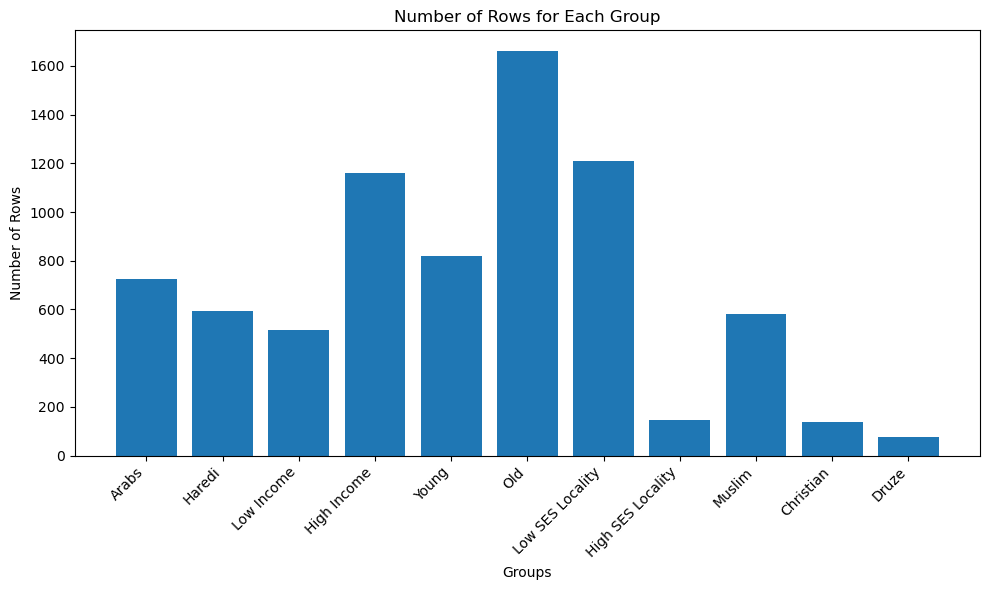

In [15]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(group_counts.keys(), group_counts.values())
plt.xlabel('Groups')
plt.ylabel('Number of Rows')
plt.title('Number of Rows for Each Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()